##  Graphs, Sparse Matrices and Applications
---
<img src="https://miro.medium.com/max/1750/1*V-5yjLcZajucFtL9z-OeIg.png" width="80%"/>


[Image Source](https://miro.medium.com/max/1750/1*V-5yjLcZajucFtL9z-OeIg.png)

---
**Agenda**

 >- What are sparse matrices. 
 >- Measure of sparseness.
 >- Why are sparse matrices needed to be dealt differently?
 >- Application areas.
 >- Various data-types for sparse matrices. 
 >- Conversion from dense to sparse (CSR) matrices and vice-versa.
 >- Graphs and their matrix representation.
 >- Operations on Sparse Matrices.
 >- Solving problems with sparse matrices.
 >- Power iterations for dominant eigenvalue and associated eigenvector.
 >- Applications: Page-ranks
 >- Applications: Spectral Clustering
 >- QR Algorithm for Eigenvalues

<br><br><br><br>

**References**
- Fundamentals
 >1. Chapter 10 Elden on Graphs and Matrices.
 >1. Chapter 13 Elden on Page Ranking.
 >1. Chapter 16 Elden on Spectral Graph Partitioning.

- Advanced
 >1. Mining Large Graphs, [Gleich and Mahoney](https://www.cs.cornell.edu/courses/cs6241/2020sp/readings/Gleich-2016-mining.pdf).
 >1. William L Hamilton [Graph Representation Learning](https://www.cs.mcgill.ca/~wlh/grl_book/files/GRL_Book.pdf).
 >1. Iterative Methods for Sparse Linear Systems, Yousef Saad. ([Online](https://www-users.cs.umn.edu/~saad/IterMethBook_2ndEd.pdf))
 >1. [A Survey of Direct Methods for Sparse Linear Systems](http://faculty.cse.tamu.edu/davis/publications_files/survey_tech_report.pdf) by Davis et. al.
- Easy Reads  
 >1. [SciPy Sparse Documentation](https://docs.scipy.org/doc/scipy/reference/sparse.html)
 >1. Read the [blog](https://dziganto.github.io/Sparse-Matrices-For-Efficient-Machine-Learning/) by David Ziganto for a comparison between sparse and dense representations of the data matrix in machine learning.
 >1. Another [blog](https://machinelearningmastery.com/sparse-matrices-for-machine-learning/) by Jason Brownlee.
 >1. [WikiPedia: Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix)

<br>

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer,ENGLISH_STOP_WORDS

import time

np.random.seed(100)
%matplotlib inline

#!jt -t grade3 -fs 110 -altp -tfs 20 -nfs 110 -cellw 90% -T


<div class="alert alert-success">
<strong>Sparse matrices</strong> have higher fraction of zero elements than nonzero elements.

<br>

$$\textrm{sparsity}(A) = \frac{\# (a_{ij}=0)}{m \times n} = 1 - \textrm{density(A)}
$$ </div>
<br>
<strong>Computational Advantages</strong>

>- Better Memory Management as smaller percentage of RAM is needed to load the matrix with appropriate data structure.
>- Computational Efficiency resulting from avoiding operations with zero elments.

<br><br>

### Visualization of a sparse matrix.
---
The Matplotlib function **spy()** could be used to visualize a sparse matrix and its sparsity and structure (or lack thereof).

--- 
#### Example of a **structured** sparse matrix.

<img src='./images/Graph1.png' width='50%' />

 #### Visualization of the adjacency matrix of the undirected graph above. 

<img src='./images/Graph1AM.png' width='30%' />

[Image Credit: Saad](https://www-users.cs.umn.edu/~saad/IterMethBook_2ndEd.pdf)

---
#### Visualization of a randomly generated sparse matrix (**unstructured**). [See this](https://dziganto.github.io/Sparse-Matrices-For-Efficient-Machine-Learning/)

**Binomial Distribution** Probability of $k$ successes out of $n$ Bernoulli trials with parameter $p$:

$$\Large
p(k) = C(n,k) ~p^k ~(1-p)^{n-k}
$$

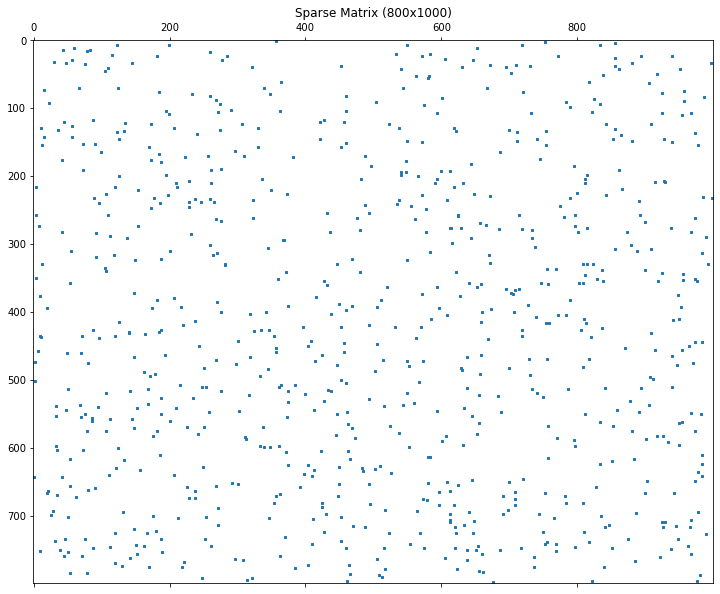

In [33]:
# Data randomly generated with binomial distribution
data = np.random.binomial(1, 0.001, 800000).reshape(800,1000)
plt.figure(figsize=(20,10))
#plt.axis("off")
plt.spy(data, marker='s', markersize=2)
plt.title("Sparse Matrix (800x1000)");

#### Storage size comparison

In [35]:
# Data randomly generated with binomial distribution
data = np.random.binomial(1, 0.001, 30000000).reshape(3000,10000)
sparse_dataset = csr_matrix(data)
full_size = data.nbytes/(1024**2)
csr_size = sparse_dataset.data.size/(1024**2)
print('Size of full matrix with zeros: '+ '%3.2f' %full_size + ' MB')
print('Size of CSR matrix: '+ '%3.2f' %csr_size + ' MB')

Size of full matrix with zeros: 228.88 MB
Size of CSR matrix: 0.03 MB


In [36]:
sparse_dataset.getnnz()

29847

### Data-structure for sparse matrices
---
- Allows efficient creation and  modification

  - Dictionary of Keys (DOK): {(row, col):val,...}
  
  - List of Lists (LIL):
  
  - Coordinate Lists (COO): {(row, col, val),...} ideally sorted by row and column.

- Efficient access and operations

  - Compressed Sparse Row (CSR)
  
  - Compressed Sparse Column (CSC)


#### Compressed Sparse Row (CSR) representation
---
Three one-dimensional arrays: VAL, COL-INDEX, and ROW-INDEX. To populate these arrays. We move from top-left corner of the matrix and traverse through all nonzero element along every column from left to right and every row from top to bottom. See the example from class. 

<img src="https://op2.github.io/PyOP2/_images/csr.svg" width="90%" />

[Image Source](https://op2.github.io/PyOP2/_images/csr.svg)

**Salient points of CSR representation**
>- Fast row access and matrix vector multiplication.
>- Saves memory only when number of nonzero elements, $NNZ < \frac{m(n-1)-1}{2}$.
>- First value in ROW-INDEX = 0, last value = NNZ, number of rows = length - 1.

<div class="alert alert-success">
<strong>Example 1</strong>: Find the CSR representation of the following
<br>
$$
A = \begin{pmatrix}
1 & 2 &  0 &  0 &  0 &  0 \\
 0 & 3 &  0 & 4 &  0 &  0 \\
 0 &  0 & 5 & 6 & 7 &  0 \\
 0 &  0 &  0 &  0 &  0 & 8 \\
 9 &  0 &  10 &  0 &  0 & 0 \\
\end{pmatrix}
$$
</div>
<br>
Answer: 
<div style="display:">
\begin{align}
\textrm{VAL} &=[1,\, 2,\, 3,\, 4,\, 5,\, 6,\, 7,\, 8,\, 9,\, 10], \\
\textrm{COL-INDEX} &=[0,\, 1,\, 1,\, 3,\, 2,\, 3,\, 4,\, 5,\, 0,\, 2], \\
\textrm{ROW-INDEX} &=[0,\, 2,\, 4,\, 7,\, 8,\, 10].
\end{align}
    </div>

###  Graphs and  Matrices
---
<div class="alert alert-info">
A <strong>graph</strong> $G$ is a collection of nodes, $V$, and edges, $E$, between the nodes.

$$ G = (V,\;E), \textrm{ where } V = \{v_1, v_2,\cdots, v_n \}, \textrm{ and }E \subset V \times V.
$$
</div>

The **adjacency matrix** of a directed graph, 
$$A = \left[a_{ij}\right]_{n\times n} \textrm{ where } a_{ij}= \begin{cases}1, \quad  (i,\,j) \in E \\ 0,\quad \textrm{ otherwise } \end{cases}$$
where $(i,\, j)$ denotes an edge from node $i$ to node $j$. 
<img src="https://o.quizlet.com/nAOxUwjgRuC8KkzxtsGA4g.png" width='50%' />

[Image Source](https://o.quizlet.com/nAOxUwjgRuC8KkzxtsGA4g.png)

The **adjacency matrix** of an undirected graph, 
<img src='https://mathworld.wolfram.com/images/eps-gif/AdjacencyMatrix_1002.gif' width='50%' />

[Image Source](https://mathworld.wolfram.com/images/eps-gif/AdjacencyMatrix_1002.gif)
>- **Note**: the adjacency matrix of an undirected graph is symmetric as $a_{ij} = a_{ji}$.
>- **Weighted adjacency matrix** has some numerical weights for every edge in the (weighted) graph.

<img src="./images/WeightedAdjMat.png" width='50%' />


**Degree Matrix**

$$
D = \text{diag}(Ae),\quad \text{ where }\quad e = (1,1,\cdots,1)^T.
$$

<div class="alert alert-success">
<strong>Proposition (Elden p107)</strong> The entries of the $m$-th power of the adjacency matrix $A$ of a simple graph, $[A^m]_{ij}$ is the number of different paths of length $m$ from vertices $i$ to $j$.
</div>

<div class="alert alert-success">
<strong>Homework Question</strong>: Find the weighted adjacencey matrix of the following graph and represent that as a csr-matrix.
</div>
<br>
<img src="https://www.researchgate.net/profile/John_Lee83/publication/220863116/figure/fig1/AS:669516962988037@1536636691241/An-example-of-a-directed-graph-with-9-nodes.png" width='50%'/>

[Image Source](https://www.researchgate.net/profile/John_Lee83/publication/220863116/figure/fig1/AS:669516962988037@1536636691241/An-example-of-a-directed-graph-with-9-nodes.png)

<div class="alert alert-success">
<strong>Example 2</strong>: Find the dense representation of the  csr-matrix and find its sparseness.
<br>
VAL = [6, 9, 4, 7], COL_INDEX = [0, 1, 2, 1], ROW_INDEX = [0, 0, 2, 3, 4].
</div>

#### Properties of CSR format
---
[See Here](http://www.mathcs.emory.edu/~cheung/Courses/561/Syllabus/3-C/sparse.html)

>- The data-structure has consecutively located entries from rows.
>- No ordering of the columns are required.
>- Accessing row elements are easy but not the column elements.
>- NNZ floating points and NNZ+N+1 intgers storage is required.
>- Efficient row-slicing.
>- Slow column-slicing. Better to use Compressed Sparse Columns (CSC)
>- Fast matrix vector multiplication.
>- Changes to sparsity structure is expensive. Use List of List (LIL) or Dictionary of Keys (DoK) in this case.

#### Example: Term-Document Matrices

In [44]:
d1 = " I bought this game as a gift for my 8 year old daughter who loves games. I was expecting lots of gross foods--but I was surprised at the inappropriate cards--eyeball, human burger, blood salsa, and fresh brains. Those are not foods that typical people find in their refrigerators. We do not practice cannibalism. She was very upset when I suggested that we just take out those cards. I seriously wonder who thinks that those cards are appropriate for kids. The rest of the game is funny, but I wish I would have looked through the cards before I gave it to her."
d2 = "Absolutely love Taco vs burrito. I️ bought it as a kickstarter. I️ originally bought this game because my husband and I️ love to play games with friends but most of them are not targeted to children so I️ got this to add to our collection so we had options when our friends with kids came. I’m not gonna lie I️ did No have high expectations for this to be a game for adult but I️ was Sooooo wrong!!!!!! We have now played with several different groups of friends and it’s a hit!!!!! With adults it becomes a major strategy game. I️ have Now bought it as a Christmas present bc it was so well received!!!!"
d3 = " Unlike several of the reviewers here, I didn't purchase this originally for when kids are around. I bought it because of the reviews that said the adults all loved it too! I'm always on the lookout for games playable by 2 people and this was a great one. It's incredibly simple, but brings a lot of laughs with the competition and sabotage. I'm really glad I gave this game a chance."
doc_list = [d1, d2, d3]

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,ENGLISH_STOP_WORDS
# Fit a bag of words
#vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
vectorizer = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)
vectorizer.fit(doc_list)
print ("Feature Names: \n",vectorizer.get_feature_names())
#print(ENGLISH_STOP_WORDS)

Feature Names: 
 ['absolutely', 'add', 'adult', 'adults', 'appropriate', 'bc', 'blood', 'bought', 'brains', 'brings', 'burger', 'burrito', 'came', 'cannibalism', 'cards', 'chance', 'children', 'christmas', 'collection', 'competition', 'daughter', 'did', 'didn', 'different', 'expectations', 'expecting', 'eyeball', 'foods', 'fresh', 'friends', 'funny', 'game', 'games', 'gave', 'gift', 'glad', 'gonna', 'got', 'great', 'gross', 'groups', 'high', 'hit', 'human', 'husband', 'inappropriate', 'incredibly', 'just', 'kickstarter', 'kids', 'laughs', 'lie', 'looked', 'lookout', 'lot', 'lots', 'love', 'loved', 'loves', 'major', 'old', 'options', 'originally', 'people', 'play', 'playable', 'played', 'practice', 'present', 'purchase', 'really', 'received', 'refrigerators', 'rest', 'reviewers', 'reviews', 'sabotage', 'said', 'salsa', 'seriously', 'simple', 'sooooo', 'strategy', 'suggested', 'surprised', 'taco', 'targeted', 'thinks', 'typical', 'unlike', 'upset', 'vs', 'wish', 'wonder', 'wrong', 'year'

In [47]:
# apply trasform
bow = vectorizer.transform(doc_list)
print ("Data Type of variable bow:",type(bow))
print("\n Bag of words sparse matrix:\n",bow)
#print("Bag of words matrix: \n", bow.toarray())

Data Type of variable bow: <class 'scipy.sparse.csr.csr_matrix'>

 Bag of words sparse matrix:
   (0, 95)	0.13411214497136623
  (0, 93)	0.13411214497136623
  (0, 92)	0.13411214497136623
  (0, 90)	0.13411214497136623
  (0, 88)	0.13411214497136623
  (0, 87)	0.13411214497136623
  (0, 84)	0.13411214497136623
  (0, 83)	0.13411214497136623
  (0, 79)	0.13411214497136623
  (0, 78)	0.13411214497136623
  (0, 73)	0.13411214497136623
  (0, 72)	0.13411214497136623
  (0, 67)	0.13411214497136623
  (0, 63)	0.10199574305204258
  (0, 60)	0.13411214497136623
  (0, 58)	0.13411214497136623
  (0, 55)	0.13411214497136623
  (0, 52)	0.13411214497136623
  (0, 49)	0.07920879325270094
  (0, 47)	0.13411214497136623
  (0, 45)	0.13411214497136623
  (0, 43)	0.13411214497136623
  (0, 39)	0.13411214497136623
  (0, 34)	0.13411214497136623
  (0, 33)	0.10199574305204258
  :	:
  (2, 76)	0.20537341750442553
  (2, 75)	0.20537341750442553
  (2, 74)	0.20537341750442553
  (2, 70)	0.20537341750442553
  (2, 69)	0.2053734175044255

In [40]:
print(bow.todense())

[[0.         0.         0.         0.         0.13411214 0.
  0.13411214 0.07920879 0.13411214 0.         0.13411214 0.
  0.         0.13411214 0.53644858 0.         0.         0.
  0.         0.         0.13411214 0.         0.         0.
  0.         0.13411214 0.13411214 0.26822429 0.13411214 0.
  0.13411214 0.15841759 0.07920879 0.10199574 0.13411214 0.
  0.         0.         0.         0.13411214 0.         0.
  0.         0.13411214 0.         0.13411214 0.         0.13411214
  0.         0.07920879 0.         0.         0.13411214 0.
  0.         0.13411214 0.         0.         0.13411214 0.
  0.13411214 0.         0.         0.10199574 0.         0.
  0.         0.13411214 0.         0.         0.         0.
  0.13411214 0.13411214 0.         0.         0.         0.
  0.13411214 0.13411214 0.         0.         0.         0.13411214
  0.13411214 0.         0.         0.13411214 0.13411214 0.
  0.13411214 0.         0.13411214 0.13411214 0.         0.13411214]
 [0.13718809 0.

In [48]:
print(bow.tocoo())

  (0, 95)	0.13411214497136623
  (0, 93)	0.13411214497136623
  (0, 92)	0.13411214497136623
  (0, 90)	0.13411214497136623
  (0, 88)	0.13411214497136623
  (0, 87)	0.13411214497136623
  (0, 84)	0.13411214497136623
  (0, 83)	0.13411214497136623
  (0, 79)	0.13411214497136623
  (0, 78)	0.13411214497136623
  (0, 73)	0.13411214497136623
  (0, 72)	0.13411214497136623
  (0, 67)	0.13411214497136623
  (0, 63)	0.10199574305204258
  (0, 60)	0.13411214497136623
  (0, 58)	0.13411214497136623
  (0, 55)	0.13411214497136623
  (0, 52)	0.13411214497136623
  (0, 49)	0.07920879325270094
  (0, 47)	0.13411214497136623
  (0, 45)	0.13411214497136623
  (0, 43)	0.13411214497136623
  (0, 39)	0.13411214497136623
  (0, 34)	0.13411214497136623
  (0, 33)	0.10199574305204258
  :	:
  (2, 76)	0.20537341750442553
  (2, 75)	0.20537341750442553
  (2, 74)	0.20537341750442553
  (2, 70)	0.20537341750442553
  (2, 69)	0.20537341750442553
  (2, 65)	0.20537341750442553
  (2, 63)	0.15619177760503056
  (2, 62)	0.15619177760503056
  (2

In [49]:
# How many non-zero elements are there?
bow.nnz

108

In [50]:
# Values
bow.data

array([0.13411214, 0.13411214, 0.13411214, 0.13411214, 0.13411214,
       0.13411214, 0.13411214, 0.13411214, 0.13411214, 0.13411214,
       0.13411214, 0.13411214, 0.13411214, 0.10199574, 0.13411214,
       0.13411214, 0.13411214, 0.13411214, 0.07920879, 0.13411214,
       0.13411214, 0.13411214, 0.13411214, 0.13411214, 0.10199574,
       0.07920879, 0.15841759, 0.13411214, 0.13411214, 0.26822429,
       0.13411214, 0.13411214, 0.13411214, 0.53644858, 0.13411214,
       0.13411214, 0.13411214, 0.07920879, 0.13411214, 0.13411214,
       0.13718809, 0.13718809, 0.13718809, 0.13718809, 0.13718809,
       0.13718809, 0.13718809, 0.13718809, 0.13718809, 0.13718809,
       0.10433508, 0.13718809, 0.13718809, 0.27437618, 0.13718809,
       0.0810255 , 0.13718809, 0.13718809, 0.13718809, 0.13718809,
       0.13718809, 0.13718809, 0.13718809, 0.0810255 , 0.24307649,
       0.41156427, 0.13718809, 0.13718809, 0.13718809, 0.13718809,
       0.13718809, 0.13718809, 0.13718809, 0.13718809, 0.24307

In [51]:
# Column-indices
bow.indices

array([95, 93, 92, 90, 88, 87, 84, 83, 79, 78, 73, 72, 67, 63, 60, 58, 55,
       52, 49, 47, 45, 43, 39, 34, 33, 32, 31, 30, 28, 27, 26, 25, 20, 14,
       13, 10,  8,  7,  6,  4, 94, 91, 86, 85, 82, 81, 71, 68, 66, 64, 62,
       61, 59, 56, 51, 49, 48, 44, 42, 41, 40, 37, 36, 32, 31, 29, 24, 23,
       21, 18, 17, 16, 12, 11,  7,  5,  3,  2,  1,  0, 89, 80, 77, 76, 75,
       74, 70, 69, 65, 63, 62, 57, 54, 53, 50, 49, 46, 38, 35, 33, 32, 31,
       22, 19, 15,  9,  7,  3], dtype=int32)

In [52]:
#Row_pointer-indices
bow.indptr

array([  0,  40,  80, 108], dtype=int32)

In [55]:
bow==bow.tocoo()

<3x96 sparse matrix of type '<class 'numpy.bool_'>'
	with 288 stored elements in Compressed Sparse Row format>

#### Sparse vs Dense Matrix Multiplication: Efficiency Comparison

In [56]:
W = np.random.binomial(n=1, p=0.005, size=(4000, 800))
start=time.time()
np.dot(W,W.T)
end=time.time()
dense_time = end - start 
print ('Dense Multiplication: {}'.format(dense_time ))

Dense Multiplication: 6.925526857376099


In [58]:
spW = csr_matrix(W)
start=time.time()
spW.dot(spW.transpose())
end=time.time()
sparse_times = end - start
print ('Sparse Multiplication:{}'.format(sparse_times))

Sparse Multiplication:0.006876945495605469


#### CSR matrix and dense vector maultiplication

In [59]:
# Following implements the algorithms in Elden page 207
def csr_mult(val, colind, rowptr, x):
    #Compute Ax where A is in CSR format
    m = rowptr.shape[0]-1
    y = np.zeros(m)
    for i in range(m):
        nnz_row_i = slice(rowptr[i],rowptr[i+1])
        a_i_nnz = val[nnz_row_i]
        print("row ",i," :",a_i_nnz)
        y[i]=np.dot(a_i_nnz,x[colind[nnz_row_i]])
    return y

In [61]:
# Following example from the CSR matrix in the definition.
rowptr=np.array([0,2,4,7,11,14],dtype=int)
colind = np.array([0,4,0,1,1,2,3,0,2,3,4,1,3,4],dtype=int)
val = np.array([10, -2, 3, 9, 7, 8, 7, 3, 8, 7, 5, 8, 9, 13],dtype=float)
x=np.array([1,1,1,1,1],dtype=float)
y = csr_mult(val, colind, rowptr, x)
print(y)

row  0  : [10. -2.]
row  1  : [3. 9.]
row  2  : [7. 8. 7.]
row  3  : [3. 8. 7. 5.]
row  4  : [ 8.  9. 13.]
[ 8. 12. 22. 23. 30.]


#### Sparse Matrix Multiplication for different data-structure
---
Let's look at the code [provided here](http://www.mathcs.emory.edu/~cheung/Courses/561/Syllabus/3-C/sparse.html).

#### Working with scipy.sparse
---
>- For efficiently constructig sparse matrices, use DOK or LIL or COO. LIL supports slicing and convenient indexing. 

>- For modifications, or matrix operations (multiplication, addition) use CSR format for $Ax$ (or CSC format for $A^Tx$).

>- Conversions among different formats is linear time. So it is is generally efficient to choose correct data format based on need.

### Graphs and Matrices
---
**Matrices and Probabilites could be viewed as graphs**. Please read this [blog/lecture notes](https://www.math3ma.com/blog/matrices-probability-graphs) to understand how.

<div class="alert alert-success">
<strong>Example</strong>: If $A$ is the adjacency matrix of a graph,  then what does $PAP^T$ represent?
</div>
<br>
<div style="display:">ANSWER: This amounts to relabeling of the nodes of the graph. (<strong>Graph-isomorphism</strong>).</div>

<br>


**Incidence Matrix**: [See Science Direct](https://www.sciencedirect.com/topics/mathematics/incidence-matrix)
<div class="alert alert-success">
<strong>Example</strong>: Find the graph whose incidence matrix is given below.
<br>
$$
A = \begin{pmatrix}
-1 & 0 &  0 &  0 &  0 &  1 \\
 1 & -1 &  0 & 0 &  0 &  0 \\
 0 &  1 & -1 & 0 & 0 &  0 \\
 0 &  0 &  1 &  -1 &  0 & 0 \\
 0 &  0 &  0 &  1 &  -1 & 0 \\
 0 &  0 &  0 &  0 &  1 & -1 \\
\end{pmatrix}
$$
</div>

### Connectedness and Reducibility

An undirected graph is **connected** if there is no subgraph isolated from the rest of the graph. This means one can traverse from one node to any other node.


A symmstric matrix $A$ is called **reducible** if there exists a permutation matrix $P$ such that $PAP^T$ is **block-diagonal**.
$$
PAP^T = 
\begin{pmatrix}
A_1 & 0\\
0 & A_2
\end{pmatrix}
$$
In the absence of such a permutation matrix, the matrix $A$ is called, **irreducible**.
<div class="alert alert-success">
<strong>Proposition 10.2 (Elden)</strong>: An undirected graph is connected if and only of its adjacency matrix is irreducible.
</div>

A general square matrix $A$ is called **reducible** if there exists a permutation matrix $P$ such that $PAP^T$ is **block-upper-triangular**, i.e., there exist matrices $X$, $Y$ and $Z$ such that
$$
PAP^T = 
\begin{pmatrix}
X & Y\\
0 & Z
\end{pmatrix}
$$
In the absence of such a permutation matrix, the matrix $A$ is called, **irreducible**.

<div class="alert alert-success">
<strong>Proposition</strong>: A directed graph is strongly connected if and only if its adjacency matrix is irreducible.
</div>

<div class="alert alert-warning">
<strong>Laplacian</strong> of a simple graph (unweighted, undirected, no self-loops, no multi-edges) is defined as a square matrix, $L = D-A$, where $D$ is the diagonal matrix made of the degree of each node, and $A$ is the adjacency matrix.
<br>

$$\large
L_{ij} := \begin{cases}
  \deg(v_i) & \mbox{if}\ i = j \\
         -1 & \mbox{if}\ i \neq j\ \mbox{and}\ v_i \mbox{ is adjacent to } v_j \\
          0 & \mbox{otherwise}
\end{cases}
$$
</div>

<img src="./images/Laplacian.png" width='90%' />

Image source: [WikiPedia](https://en.wikipedia.org/wiki/Laplacian_matrix)

<div class="alert alert-success">
<strong>Homework</strong>: Verify the following where $L$ is the Laplacian (in undirected sense) and $C$ is the <strong>oriented incidence matrix</strong>:
$$ L  = CC^T$$
</div>


<br>

<div class="alert alert-success">
<strong>Normalized Laplacian</strong>:
A symmetric normalized form of Laplacian matrix is given by

$$\large
L_N := D^{-\frac{1}{2}} L D^{-\frac{1}{2}} = I - D^{-\frac{1}{2}} A D^{-\frac{1}{2}}.
$$
The elements of  $L_N$ are given by

$$\large
[L_N]_{ij} := 
\begin{cases}
                                     1 & \mbox{if } i = j \mbox{ and } \deg(v_i) \neq 0\\
  -\frac{1}{\sqrt{\deg(v_i)\deg(v_j)}} & \mbox{if } i \neq j \mbox{ and }(i,\, j) \in E\\
                                     0 & \mbox{otherwise}.
\end{cases}
$$
</div>

**Note that** 

>- $D^{1/2}e$ is an eigenvector of $L_N$ associated with eigenvalue 0.

>- A symmetric diagonally dominant matrix $A$ with real non-negative  entries on the diagonal is positive semidefinite.


<div class="alert alert-success">
<strong>Lemma 10.3 (Elden)</strong>: The eigenvalues of $L_N$ are all nonnegative real numbers.
</div>

<div class="alert alert-info">
<strong>Spectral Properties</strong>: Prove the following statements about the Laplacian $L = D-A$.
<li> $L$ is symmetric and positive semi-definite.</li>
<li> $0=\lambda_1 \le \lambda_2 \le \cdots \le \lambda_{n}$</li>
<li> Sum of every row and column is zero.</li>
<li> $L$ has at least one zero eigenvalue implying singularity.</li>
<li> The dimension of the null-space of $L$ gives the total number of connected components in the graph.</li>
<li> trace$(L)=2m$, where $m$ is the number of edges.</li>
</div>

(See Elden)

<div class="alert alert-success">
<strong>Proposition 10.4 (Elden)</strong> Assume that an undirected graph is connected. Then the second smallest eigenvalue $\lambda_2$ of its normalized Laplacian $L_N $is positive.
</div>

#### Some salient points about $L$
>- Spectral Gap: the smallest non-zero eigenvalue of $L$.
>- Algebraic connectivity (or Fiedler value) of the graph: the second smallest eigenvalue  $\lambda_2$ of $L$ (related with the **sparsest cut** of the graph). The corresponding eigenvector is called Fiedler vector.
>- $L$ is a block diagonal matrix if the graph has multiple connected components (upons possible relabeling of vertices).

"The **sparsest cut problem** is to bipartition the vertices so as to minimize the ratio of the number of edges across the cut divided by the number of vertices in the smaller half of the partition. This objective function favors solutions that are both sparse (few edges crossing the cut) and balanced (close to a bisection)."--WikiPedia

#### Eigenvalues of graph Laplacian: An example
---
<img src="https://miro.medium.com/max/1400/1*p2vrLlFxdJgGZxCGO5WBmA.gif" width='70%'>

[Image Credit](https://miro.medium.com/max/1400/1*p2vrLlFxdJgGZxCGO5WBmA.gif)

---

### Applications of Spectral Graphs Theory

---
<br>

#### Application: Google Page Ranking (Look at the other notebook on pageranking.)

Continued on iPad.

Reference 1: Numerical Linear Algebra in Data Mining-[Elden](http://www.cato.tzo.com/brad_bbk/teaching/datamining/research_surveys/elden.pdf), Page 40-46.

Reference 2: Please see [this link](https://rstudio-pubs-static.s3.amazonaws.com/239261_8a607707294341c4b7e26acf728c28bd.html) on power iteration and page-rank.

---

**Power-iteration** [WikiPedia](https://en.wikipedia.org/wiki/Power_iteration)

An iterative algorithm to find the dominant eigenvalue and associated eigenvector of certain matrices.

Start with a random initialization $v_0$ repeat until convergence

$$\large
v_{k+1} = \frac{Av_k}{\|Av_k\|} ;\qquad \lambda_{k} = \frac{v_{k+1}Av_{k}}{v_{k+1}v_{k}}
$$

Necessary and sufficient condition for convergence
>1. The dominant eigenvalue must  be larger than every other eigenvalue in magnitude. rate of convergence is proportional to $|\lambda_2/\lambda_1|$
>2. The initialization $v_0$ must have a nonzero component along the eigenvector associated with the dominant eigenvalue.

In [64]:
import numpy as np
def power_method(A, max_iter):
    v_old = np.random.rand(A.shape[1]) # Why should you choose randomly
    #csrA = csr_matrix(A)
    for k in range(max_iter):
        v_new = A.dot(v_old)

        # Need to normalize
        v_new = v_new / np.linalg.norm(v_new)
        # Test for convergence
        v_old = v_new
        
    evalue = np.dot(v_new,A.dot(v_new))/np.linalg.norm(v_new)
    return v_new, evalue

In [65]:
power_method(np.array([[0.6, 0.2], [0.2, 0.7]]), 100)

(array([0.61541221, 0.78820544]), 0.856155281280883)

In [29]:
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
def power_method_ranking(Q,v, max_iter):
    Q_csr = csr_matrix(Q)
    z = np.random.rand(Q.shape[1]) # Why should you choose randomly
    z = np.linalg.norm(z,ord=1)
    alpha=0.85
    

    for k in range(max_iter):
        y=alpha*Q_csr.dot(z)
        beta = 1.0 - np.linalg.norm(y,ord=1, axis=0)
        z=y+beta*v
        residual = np.linalg.norm(y-z,ord=1, axis=0)
        if residual < 0.0001:
            break
    return z

In [3]:
#Example
P = np.array([[0, 0, 0, 1/3, 1/2, 0, 0, 0],
              [1/2, 0, 0, 0, 0, 1/2, 0, 0],
              [1/2, 0, 0, 0, 0, 0, 1/2, 0],
              [0, 1/2, 1, 0, 0, 0, 0, 0],
              [0, 1/2, 0, 0, 0, 0, 1/2, 1/2],
              [0, 0, 0, 0, 1/2, 0, 0, 0],
              [0, 0, 0, 1/3, 0, 0, 0, 1/2],
              [0, 0, 0, 1/3, 0, 1/2, 0, 0]],dtype=float)

In [8]:
#np.linalg.eig(P)
ev, r = power_method(P,1000)
print(ev)

[0.38270083 0.30069351 0.34169717 0.49204393 0.43737238 0.21868619
 0.30069351 0.27335774]


In [7]:
np.argsort(ev)+1

array([6, 8, 7, 2, 3, 1, 5, 4])

In [22]:
#Example
np.set_printoptions(precision=2)
Q = np.array([[0, 1/4, 0, 0, 0, 0, 0, 0],
              [1/4, 0, 1/2, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 1/2, 0, 0, 1/2],
              [1/4, 0, 0, 0, 0, 0, 0, 0],
              [0, 1/4, 0, 1/3, 0, 1/3, 0, 0],
              [1/4, 1/4, 1/2, 0, 0, 0, 0, 1/2],
              [1/4, 0, 0, 1/3, 1/2, 1/3, 0, 0],
              [0, 1/4, 0, 1/3, 0, 1/3, 0, 0]],dtype=float)

P = np.copy(Q)
n=P.shape[0]
alpha = 0.85
A = alpha * P + np.ones_like(P, dtype=float)*(1-alpha)/n
print(P)
print(A)

[[0.   0.25 0.   0.   0.   0.   0.   0.  ]
 [0.25 0.   0.5  0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.5  0.   0.   0.5 ]
 [0.25 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.25 0.   0.33 0.   0.33 0.   0.  ]
 [0.25 0.25 0.5  0.   0.   0.   0.   0.5 ]
 [0.25 0.   0.   0.33 0.5  0.33 0.   0.  ]
 [0.   0.25 0.   0.33 0.   0.33 0.   0.  ]]
[[0.02 0.23 0.02 0.02 0.02 0.02 0.02 0.02]
 [0.23 0.02 0.44 0.02 0.02 0.02 0.87 0.02]
 [0.02 0.02 0.02 0.02 0.44 0.02 0.02 0.44]
 [0.23 0.02 0.02 0.02 0.02 0.02 0.02 0.02]
 [0.02 0.23 0.02 0.3  0.02 0.3  0.02 0.02]
 [0.23 0.23 0.44 0.02 0.02 0.02 0.02 0.44]
 [0.23 0.02 0.02 0.3  0.44 0.3  0.02 0.02]
 [0.02 0.23 0.02 0.3  0.02 0.3  0.02 0.02]]


In [10]:
lmbda,V = np.linalg.eig(P)
print(V[:,0])
print(P@V[:,0])

[0.14+0.j 0.56+0.j 0.31+0.j 0.03+0.j 0.31+0.j 0.49+0.j 0.37+0.j 0.31+0.j]
[0.14+0.j 0.56+0.j 0.31+0.j 0.03+0.j 0.31+0.j 0.49+0.j 0.37+0.j 0.31+0.j]


In [30]:
#v,eig_1 = power_method(P,1000)
#print(v)
#print(P@v)
z= power_method_ranking(Q,np.ones((8,1),dtype=float),1000)
print(v2)

AxisError: axis 0 is out of bounds for array of dimension 0

## Application: Clustering
---

<img src="./images/Kmeans1.png" width='80%' />

---

<img src="./images/Kmeans2.png" width='80%' />

---

<img src="./images/Kmeans3.png" width='80%' />

---

<img src="./images/Kmeans4.png" width='80%' />

---

####  Clustering application: Color quantization

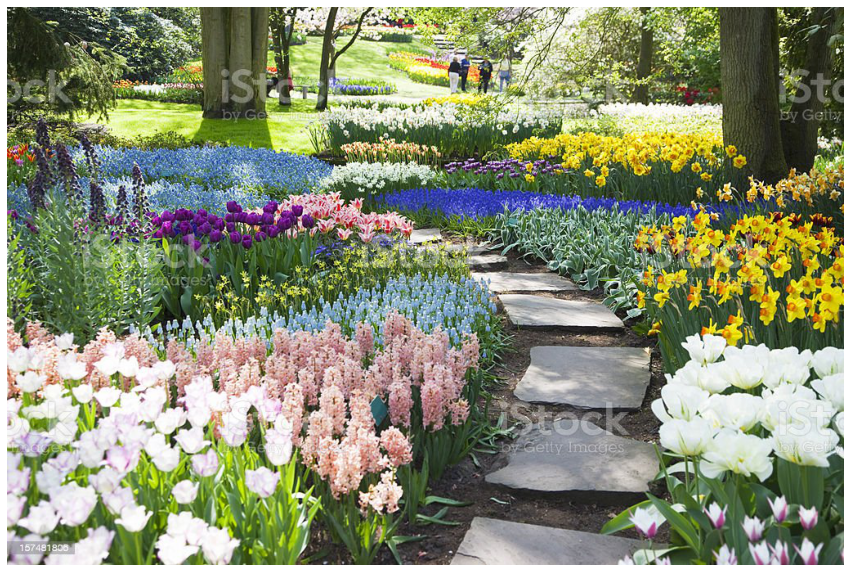

Original dimension of the image
(683, 1024, 3)
After vectorizing the image, the dimensions are:
(699392, 3)


In [119]:
import matplotlib.image as mpimg
from sklearn.cluster import KMeans

# Load an image of yoour choice
f = mpimg.imread("./images/flowers.jpeg") 
# misc.imsave('face.png', f) # uses the Image module (PIL)

plt.figure(figsize=(15,25))
plt.axis('off')
plt.imshow(f)
plt.show()


dim = f.shape
print ("Original dimension of the image")
print (dim)

X = f.reshape(-1,3)/255.0
print ("After vectorizing the image, the dimensions are:" )
print (X.shape)


In [110]:
# Create the clustering object with 10 clusters
n_cl =100
km = KMeans(n_clusters=n_cl, max_iter=1000, init='random', n_init=5)

In [111]:
# Train
km.fit(X)

KMeans(init='random', max_iter=1000, n_clusters=100, n_init=5)

In [112]:
print ("The cluster centers are:")
cs = np.round( km.cluster_centers_, 3)
print(cs)

The cluster centers are:
[[0.708 0.804 0.918]
 [0.504 0.171 0.085]
 [0.28  0.378 0.297]
 [0.851 0.71  0.228]
 [0.188 0.261 0.368]
 [0.556 0.633 0.52 ]
 [0.522 0.583 0.429]
 [0.811 0.872 0.54 ]
 [0.971 0.972 0.892]
 [0.554 0.622 0.321]
 [0.109 0.121 0.084]
 [0.301 0.29  0.279]
 [0.538 0.639 0.193]
 [0.125 0.18  0.039]
 [0.655 0.662 0.66 ]
 [0.963 0.935 0.369]
 [0.587 0.442 0.047]
 [0.739 0.613 0.053]
 [0.454 0.574 0.087]
 [0.253 0.261 0.165]
 [0.343 0.451 0.358]
 [0.423 0.426 0.391]
 [0.366 0.36  0.329]
 [0.868 0.621 0.528]
 [0.882 0.905 0.877]
 [0.193 0.196 0.177]
 [0.789 0.404 0.065]
 [0.724 0.553 0.537]
 [0.557 0.565 0.588]
 [0.187 0.269 0.176]
 [0.952 0.944 0.956]
 [0.96  0.857 0.84 ]
 [0.821 0.862 0.667]
 [0.251 0.34  0.147]
 [0.569 0.701 0.072]
 [0.778 0.628 0.622]
 [0.167 0.218 0.116]
 [0.146 0.158 0.127]
 [0.699 0.78  0.365]
 [0.854 0.703 0.678]
 [0.311 0.437 0.61 ]
 [0.4   0.519 0.465]
 [0.533 0.66  0.711]
 [0.702 0.707 0.71 ]
 [0.343 0.422 0.249]
 [0.95  0.973 0.787]
 [0.764 0

In [113]:
# Let's print all the color-clusters in some stripes
centroids = km.cluster_centers_.reshape(1, n_cl,3)
temp = np.zeros((20, n_cl, 3), dtype=int)
color_map = np.add(temp, centroids)
color_map.shape

(20, 100, 3)

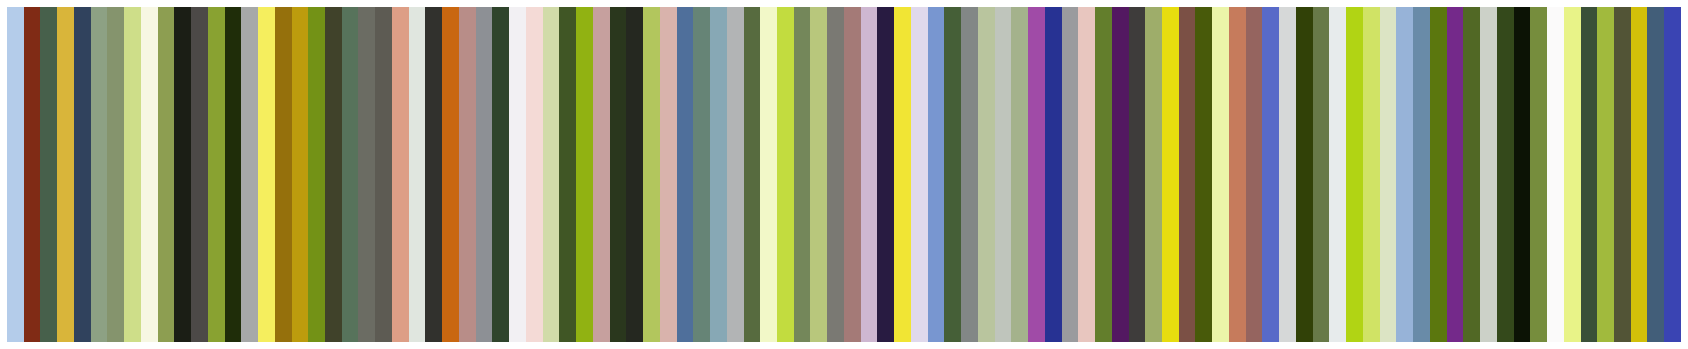

In [116]:
#Different color labels
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(color_map)
plt.show()

In [117]:
# Get the cluster labels for each color
Xin = km.labels_

km_labels = km.labels_
print (km_labels.shape)

# The cat image in new colors
Xnew = cs[Xin,:]

# Bring it back to original dimensions
Xnim = Xnew.reshape(dim)

(699392,)


(-0.5, 1023.5, 682.5, -0.5)

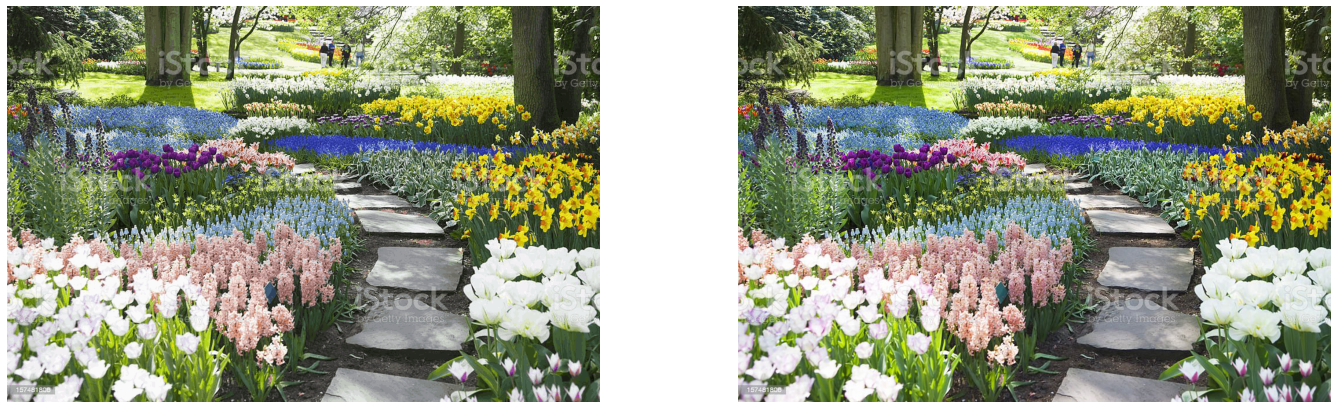

In [118]:
# Print the two pictures
fig = plt.figure(figsize=(24,16))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(Xnim)
plt.axis('off')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(f)
plt.axis('off')

#### Trouble with K-means Clustering: 
<img src="./images/KmeansSpectral.png" width='70%' />

### Spectral Clustering
---

<img src="./images/SpectralClusterIBM.png" width='80%' />

[Image Credit: IBM Research](https://www.ibm.com/blogs/research/2018/08/spectral-clustering/)

Reference: [A WikiBook from University of Denver](http://math.ucdenver.edu/~sborgwardt/wiki/index.php/Spectral_clustering)

[A Stanford University Lecture](https://www.youtube.com/watch?v=uxsDKhZHDcc)

[MIT - A Tutorial on Spectral Clustering](http://people.csail.mit.edu/dsontag/courses/ml14/notes/Luxburg07_tutorial_spectral_clustering.pdf)

#### Three Steps for Spectral Clustering

**Step 1: Preprocessing**
>- Given a data set $X$, create an affinity graph, $G$ based on some appropriate notion of 'similarity' between every pair of data-points. Find its weighted adjacency matrix, $W$,  that wil be used for creating a normalized symmetric Laplacian, $\mathcal{L}$, for the graph.

**Step 2: Decomposition**
>- Perform spectral decomposition of the Laplacian. Pick up the smallest $k$ of the eigenvalues and asociated eigenvectors. Let $\tilde{U} \in \mathbb{R}^{n\times k}$ be the matrix formed by these eigenvectors.

**Step 3: Grouping**
>- Perform K-means clustering for grouping the rows of $\tilde{U}$.
>- If row $j$ of $\tilde{U}$ belongs to cluster $p$ then the data-point $j$ is assigned cluster membership to $p$.

#### Some salient points about $L$
>- Spectral Gap: the smallest non-zero eigenvalue of L.
>- Algebraic connectivity (or Fieder value) of the graph: the second smallest eigenvalue of L (related with the **sparsest cut** of the graph)
>- $L$ is a block diagonal matrix if the graph has multiple connected components (upons possible relabeling of vertices).

"The **sparsest cut problem** is to bipartition the vertices so as to minimize the ratio of the number of edges across the cut divided by the number of vertices in the smaller half of the partition. This objective function favors solutions that are both sparse (few edges crossing the cut) and balanced (close to a bisection)."--WikiPedia

**Example**: [Clusterign on Credit-card data](https://www.geeksforgeeks.org/ml-spectral-clustering/)

**Comparison of different clusterign algorithms on some toy data**:[Scikit Documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py)
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png" />


<div class="alert alert-danger">
(Naive) spectral clustering suffers due to high computational complexity and is not quite useful for large datasets. Read this [article from IBM Reasearch](https://www.ibm.com/blogs/research/2018/08/spectral-clustering/) to get an idea of how this could be better tackled by exploiting sparsity and better algorithms.
</div>

### QR Algorithm for Eigenvalues and eigenvectors
---
>- Step 1: Intialize: $A_0 = A$
>- Step 2: Repeat until convergence k=0:MaxIterations
    >>-  Find QR decomposition of $A_k = Q_k R_k$
    >>-  $A_{k+1} = R_k Q_k$ $\quad \left(= Q_k^{-1} Q_k R_k Q_k = Q_k^{-1} A_k Q_k = Q_k^{\mathsf{T}} A_k Q_k, \right)$

Under certain conditions the above converges to the **Schur Form** of $A = UTU^T$, where $T$ is upper triangular, containing all the eigenvalues on the diagonal element.

Improvement: Hessenberg Form, Shifted implicit forms.

In [1]:
%%html
<style>
.eqnbox{
    margin:auto;width:500px;padding:20px;
    border: 3px solid green; border-radius:15px;margin-top:20px;margin-bottom:20px;
}
.eqnbox2{
    margin:auto;width:500px;padding:20px;
    border: 1px solid green; border-radius:15px;margin-top:20px;margin-bottom:20px;
}
.eqnbox3{
    margin:auto;width:700px;padding:20px;background-color:#c6d6b4;
    border: 1px solid green; border-radius:15px;margin-top:20px;margin-bottom:20px;
}
</style>

In [16]:
# Example of page rank 4x4 matrix
A = np.array([[0,1/3, 1/3, 1/3],[0, 0, 1/2, 1/2],[1,0,0,0],[1/2,0,1/2,0]],dtype=float).T
print("Link Matrix:\n",A)

eVec,_ = power_method(A,100)
print(eVec)
print("Pages ranked in the increasing order of importance:", np.argsort(eVec)+1)


Link Matrix:
 [[0.         0.         1.         0.5       ]
 [0.33333333 0.         0.         0.        ]
 [0.33333333 0.5        0.         0.5       ]
 [0.33333333 0.5        0.         0.        ]]
[0.72101012 0.24033671 0.54075759 0.36050506]
Pages ranked in the increasing order of importance: [2 4 3 1]


In [20]:
rows = np.zeros((3,60),dtype='int') 
print rows 
for k in range(60):
    rows[:,k] = np.array([[k,k,k]])
    
row_index = rows.T.flatten()
print(row_index)
val = np.ones_like(row_index)
col_index = 

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[ 0  0  0  1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7  8
  8  8  9  9  9 10 10 10 11 11 11 12 12 12 13 13 13 14 14 14 15 15 15 16 16
 16 17 17 17 18 18 18 19 19 19 20 20 20 21 21 21 22 22 22 23 23 23 24 24 24
 25 25 25 26 26 26 27 27 27 28 28 28 29 29 29 30 30 30 31 31 31 32 32 32 33
 33 33 34 34 34 35 35 35 36 36 36 37 37 37 38 38 38 39 39 39 40 40 40 41 41
 41 42 42 42 43 43 43 44 44 44 45 45 45 46 46 46 47 47 47 48 48 48 49 49 49
 50 50 50 51 51 51 52 52 52 53 53 53 54 54 54 55 55 55 56 56 56 57 57 57 58
 58 58 59 59 59]


In [5]:
!jt -t grade3

In [3]:
import numpy as np
H = np.array([[1,0,0,0],[0,2/3,-2/3,1/3],[0,-2/3,-1/3,2/3],[0,1/3,2/3,2/3]],dtype='float')

In [4]:
print(H)

[[ 1.          0.          0.          0.        ]
 [ 0.          0.66666667 -0.66666667  0.33333333]
 [ 0.         -0.66666667 -0.33333333  0.66666667]
 [ 0.          0.33333333  0.66666667  0.66666667]]


In [5]:
A = np.array([[3,4,3,2],[2,1,2,5],[-2,-1,3,2],[1,4,2,5]],dtype='float')

In [6]:
print (H@A)

[[ 3.          4.          3.          2.        ]
 [ 3.          2.66666667  0.          3.66666667]
 [ 0.          2.33333333 -1.         -0.66666667]
 [ 0.          2.33333333  4.          6.33333333]]


In [2]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [7]:
list1 = [1,2,3]

In [8]:
print(list1*3)
#or use repeat.

[1, 2, 3, 1, 2, 3, 1, 2, 3]
